<a href="https://colab.research.google.com/github/Epatsili2000/ParkinsonDetection/blob/main/Baseline_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Full Acoustic Feature Extraction

This notebook extracts a wide range of acoustic features from each `.wav` file in the PC-GITA dataset. It integrates both **Librosa** and **Parselmouth (Praat)** libraries and includes speaker-level metadata from the cleaned CSV file.

####  Features Extracted:

- **MFCCs** (13) + **Δ (delta)** + **ΔΔ (delta-delta)** → mean-pooled (39 features)
- **Jitter** and **Shimmer** (from Praat)
- **Pitch (F0)** and **Harmonics-to-Noise Ratio (HNR)**
- **Formants**: F1, F2, F3 (from midpoint of the utterance)
- **Spectral features**:
  - Spectral Centroid
  - Bandwidth
  - Flatness
  - Rolloff

#### Other Configuration:
- Audio normalized to 16,000 Hz
- Silence trimmed before feature extraction
- Parallelized extraction using `joblib` (4 workers)
- GroupKFold (5-fold) used to prevent speaker leakage

####  Output Files:
- `/PCGITA_RESULTS/pcgita_index_clean.csv`: Full WAV index with metadata
- `/PCGITA_RESULTS/pcgita_index_split.csv`: GroupKFold partitioned file (train/val per fold)
- `/PCGITA_RESULTS/pcgita_features_augmented.csv`: Final dataset with all acoustic features

This dataset is used for training all traditional ML models (e.g., SVM, Logistic Regression, XGBoost).


In [ ]:

# ------------------- SETUP -------------------
from google.colab import drive
drive.mount('/content/drive')

!pip install -q librosa soundfile praat-parselmouth joblib tqdm

import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from joblib import Parallel, delayed
import librosa
import parselmouth

# ------------------- PATHS -------------------
ROOT = "/content/drive/MyDrive/PC-GITA_per_task_44100Hz/PC-GITA_per_task_44100Hz"
METADATA_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_metadata_cleaned.csv"
OUT_DIR = "/content/drive/MyDrive/PCGITA_RESULTS"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------- LOAD METADATA -------------------
def load_metadata(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    if "Speaker ID" in df.columns:
        df = df.rename(columns={"Speaker ID": "Speaker_ID"})
    df = df.dropna(subset=["Speaker_ID"])
    df = df.drop_duplicates(subset=["Speaker_ID"])
    print("🔍 Metadata columns:", df.columns.tolist())
    return df

metadata_df = load_metadata(METADATA_PATH)
speaker_meta = metadata_df.set_index("Speaker_ID").to_dict(orient="index")

# ------------------- WAV INDEXING -------------------
def parse_wav_index(root):
    records = []
    for dirpath, _, files in os.walk(root):
        for f in files:
            if not f.lower().endswith(".wav"):
                continue
            full_path = os.path.join(dirpath, f)
            rel_path = os.path.relpath(full_path, root)
            parts = Path(rel_path).parts
            task = parts[0]
            speaker_id = next((spk for spk in speaker_meta if f.startswith(spk)), None)
            label = "PD" if "parkinson" in rel_path.lower() or "patologica" in rel_path.lower() else "HC"
            meta = speaker_meta.get(speaker_id, {
                "UPDRS_total": np.nan,
                "Hoehn_Yahr": np.nan,
                "Gender": "Unknown",
                "Age": np.nan,
                "After_Diagnosis": np.nan
            })
            records.append({
                "Task": task,
                "Label": label,
                "Speaker_ID": speaker_id if speaker_id else "Unknown",
                "Relative_Path": rel_path,
                "Full_Path": full_path,
                "UPDRS_total": meta["UPDRS_total"],
                "Hoehn_Yahr": meta["Hoehn_Yahr"],
                "Gender": meta["Gender"],
                "Age": meta["Age"],
                "After_Diagnosis": meta["After_Diagnosis"]
            })
    return pd.DataFrame(records)

df = parse_wav_index(ROOT)
df = df[df["Label"].isin(["PD", "HC"])]
df.to_csv(f"{OUT_DIR}/pcgita_index_clean.csv", index=False)
print(f" Indexed {len(df)} .wav files.")

# ------------------- GROUPKFOLD SPLIT -------------------
def add_groupkfold_split(df, n_splits=5):
    df = df.copy()
    df["group_label"] = df["Label"] + "_" + df["Task"]
    splitter = GroupKFold(n_splits=n_splits)
    df["split"] = "none"
    for fold, (train_idx, val_idx) in enumerate(splitter.split(df, df["group_label"], groups=df["Speaker_ID"])):
        df.loc[val_idx, "split"] = f"val{fold+1}"
        df.loc[train_idx, "split"] = f"train{fold+1}"
    return df

df = add_groupkfold_split(df)
df.to_csv(f"{OUT_DIR}/pcgita_index_split.csv", index=False)
print(" Saved GroupKFold split file.")

# ------------------- AUDIO FUNCTIONS -------------------
def normalize_audio(path, target_sr=16000):
    y, sr = librosa.load(path, sr=None)
    y, _ = librosa.effects.trim(y)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y, target_sr

# ------------------- FEATURE EXTRACTION -------------------
def extract_features(row):
    path = row["Full_Path"]
    try:
        y, sr = normalize_audio(path)

        # MFCCs + delta + delta-delta
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        delta = librosa.feature.delta(mfcc) if mfcc.shape[1] >= 9 else np.zeros_like(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2) if mfcc.shape[1] >= 9 else np.zeros_like(mfcc)
        mfcc_feats = np.concatenate([mfcc, delta, delta2], axis=0).mean(axis=1)

        # Parselmouth
        snd = parselmouth.Sound(path)
        pp = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
        jitter = parselmouth.praat.call(pp, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = parselmouth.praat.call([snd, pp], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        # Pitch (F0)
        try:
            f0 = snd.to_pitch().get_value_in_frame(1)
        except:
            f0 = np.nan

        # HNR
        try:
            hnr = parselmouth.praat.call(snd, "Get harmonics-to-noise ratio", 0, 0)
        except:
            hnr = np.nan

        # Formants
        formants = snd.to_formant_burg()
        f1 = formants.get_value_at_time(1, snd.duration / 2)
        f2 = formants.get_value_at_time(2, snd.duration / 2)
        f3 = formants.get_value_at_time(3, snd.duration / 2)

        # Spectral features
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
        flatness = librosa.feature.spectral_flatness(y=y).mean()
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        return row.to_dict() | {
            **{f"mfcc{i+1}": v for i, v in enumerate(mfcc_feats)},
            "jitter": jitter,
            "shimmer": shimmer,
            "pitch": f0,
            "hnr": hnr,
            "formant1": f1,
            "formant2": f2,
            "formant3": f3,
            "spectral_centroid": centroid,
            "spectral_bandwidth": bandwidth,
            "spectral_flatness": flatness,
            "spectral_rolloff": rolloff
        }
    except Exception as e:
        print(f" Failed: {path} → {e}")
        return None


# ------------------- RUN EXTRACTION -------------------
print(" Extracting features in parallel...")
feature_rows = Parallel(n_jobs=4, backend="multiprocessing")(
    delayed(extract_features)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

df_features = pd.DataFrame([r for r in feature_rows if r is not None])
df_features.to_csv(f"{OUT_DIR}/pcgita_features_augmented.csv", index=False)
print(f" Feature CSV saved: {df_features.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.9 MB/s eta 0:00:00
🔍 Metadata columns: ['Task', 'Label', 'Speaker_ID', 'Relative_Path', 'Full_Path', 'UPDRS_total', 'Updrs-Speech', 'Hoehn_Yahr', 'Gender', 'Age', 'After_Diagnosis']
✅ Indexed 6414 .wav files.
✅ Saved GroupKFold split file.
🚀 Extracting features in parallel...


100%|██████████| 6414/6414 [34:23<00:00,  3.11it/s]


✅ Feature CSV saved: (6414, 62)


### Cleaning and Scaling Acoustic Features

This notebook finalizes the feature dataset by:
1. Removing unusable rows or columns
2. Imputing missing values
3. Standardizing features for use in ML models

####  Cleaning Steps
- Filters rows to keep only valid `PD` or `HC` labels.
- Drops rows missing critical metadata like `Speaker_ID`, `Relative_Path`, or `Full_Path`.
- Removes fully missing features (e.g., `hnr`).
- Imputes missing values in acoustic features with the column-wise mean.

####  Feature Columns
All acoustic columns used:
- `mfcc1`–`mfcc39`
- `jitter`, `shimmer`, `pitch`
- `formant1`–`formant3`
- `spectral_centroid`, `spectral_bandwidth`, `spectral_flatness`, `spectral_rolloff`

####  Feature Scaling
- Standardization is applied using `StandardScaler` (mean=0, std=1)
- The fitted scaler is saved for future inference or reproducibility

####  Output Files
- `pcgita_features_final_clean.csv`: Cleaned but unscaled feature set
- `pcgita_features_final_scaled.csv`: Scaled features for training models
- `scaler_features.joblib`: Saved StandardScaler object for consistent test-time scaling


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# ---------------- CONFIG ----------------
INPUT_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_augmented.csv"
CLEAN_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_clean.csv"
SCALED_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
SCALER_PATH = "/content/drive/MyDrive/PCGITA_MODELS/scaler_features.joblib"

# ---------------- LOAD ----------------
df = pd.read_csv(INPUT_CSV)
print(f" Loaded: {df.shape}")

# ---------------- CLEAN METADATA ----------------
df = df[df["Label"].isin(["PD", "HC"])]
df = df[df["Speaker_ID"].notna()]
df = df.dropna(subset=["Relative_Path", "Full_Path"])
print(f"🔹 After label/speaker cleaning: {df.shape}")

# ---------------- DROP FULLY MISSING FEATURE ----------------
if "hnr" in df.columns:
    df = df.drop(columns=["hnr"])
    print(" Dropped column: 'hnr' (fully missing)")

# ---------------- HANDLE FEATURE NaNs ----------------
feature_cols = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1).columns.tolist()

# Impute missing values with feature-wise mean
df_clean = df.copy()
df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].mean())
print(f" Imputed missing features using column mean: {df_clean.shape}")

# ---------------- SAVE CLEANED ----------------
df_clean.to_csv(CLEAN_CSV, index=False)
print(f" Cleaned features saved to: {CLEAN_CSV}")

# ---------------- NORMALIZE FEATURES ----------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clean[feature_cols])

df_scaled = df_clean.copy()
df_scaled[feature_cols] = scaled_features
df_scaled.to_csv(SCALED_CSV, index=False)
print(f" Scaled features saved to: {SCALED_CSV}")

# ---------------- SAVE SCALER ----------------
joblib.dump(scaler, SCALER_PATH)
print(f" Scaler object saved to: {SCALER_PATH}")

# ---------------- PREVIEW ----------------
print(df_scaled[["Label", "Speaker_ID"] + feature_cols[:5]].head())


📥 Loaded: (6414, 62)
🔹 After label/speaker cleaning: (6414, 62)
🧹 Dropped column: 'hnr' (fully missing)
✅ Imputed missing features using column mean: (6414, 61)
💾 Cleaned features saved to: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_clean.csv
📦 Scaled features saved to: /content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv
🧪 Scaler object saved to: /content/drive/MyDrive/PCGITA_MODELS/scaler_features.joblib
  Label     Speaker_ID     mfcc1     mfcc2     mfcc3     mfcc4     mfcc5
0    PD  AVPEPUDEA0013  0.769556 -0.246425 -0.585494  0.377273  0.219771
1    PD  AVPEPUDEA0032  0.940856  0.385419 -1.367088  0.816282  0.380970
2    PD  AVPEPUDEA0021 -0.413705 -0.435787  0.309206  0.782798  1.409550
3    PD  AVPEPUDEA0020 -1.124624 -0.213752  0.402329  0.190085  1.491627
4    PD  AVPEPUDEA0048  0.294909 -0.134995  0.644524  0.424646  0.565562


##  SVM Classifier for Parkinson's Detection (Run 2)

This notebook trains a Support Vector Machine (SVM) with RBF kernel to classify Parkinson’s Disease (PD) vs. Healthy Controls (HC) using extracted acoustic features.

###  Model Setup
- Classifier: `SVC(kernel='rbf', C=10.0, gamma=0.01, probability=True, class_weight='balanced')`
- Features used: MFCCs (1–39), jitter, shimmer, pitch, formants (F1–F3), spectral features
- Labels: Binary (`PD = 1`, `HC = 0`)
- Cross-validation: `GroupKFold(n_splits=5)` to avoid speaker leakage

###  Evaluation Metrics (per fold)
- Accuracy
- ROC AUC
- F1 Score
- Sensitivity (Recall of PD)
- Specificity (Recall of HC)

###  Outputs
- Trained models per fold: `svm_fold{n}_run2.joblib`
- Confusion matrices: `conf_matrix_fold{n}.png`
- ROC curve plot: `svm_roc_curves_run2.png`
- Performance summary: `svm_performance_summary_run2.png`
- Metrics CSV: `svm_metrics_run2.csv`



🔁 Fold 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

✅ Acc: 0.3513 | AUC: nan | Sens: 0.00 | Spec: 0.35

🔁 Fold 2/5
✅ Acc: 0.6886 | AUC: 0.8642 | Sens: 0.57 | Spec: 0.90

🔁 Fold 3/5
✅ Acc: 0.6565 | AUC: 0.8196 | Sens: 0.53 | Spec: 0.88

🔁 Fold 4/5
✅ Acc: 0.7024 | AUC: 0.8487 | Sens: 0.60 | Spec: 0.88

🔁 Fold 5/5
✅ Acc: 0.6746 | AUC: 0.8449 | Sens: 0.57 | Spec: 0.86

📊 Metrics saved to /content/drive/MyDrive/PCGITA_MODELS/models_svm/svm_metrics_run2.csv


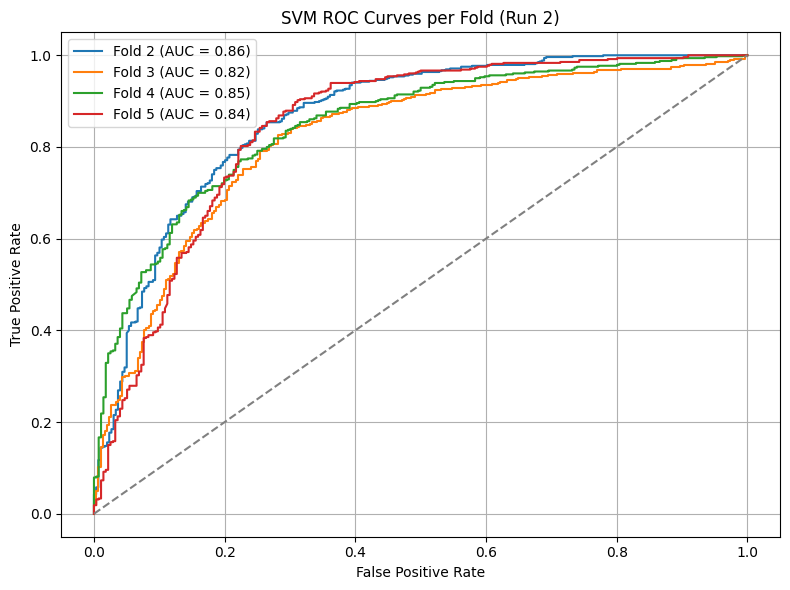

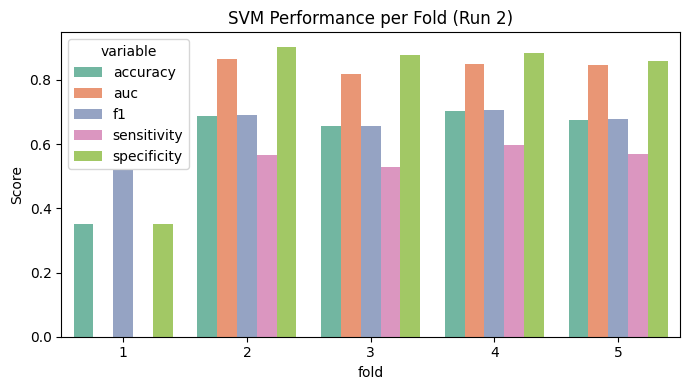

📁 All plots saved to /content/drive/MyDrive/PCGITA_MODELS/models_svm/SVM_plots


In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, recall_score
)
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/models_svm"
PLOT_DIR = os.path.join(MODEL_DIR, "SVM_plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]

# -------------------- FEATURES & TARGET --------------------
X = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y = df["Label"].map({"PD": 1, "HC": 0})
groups = df["Speaker_ID"]

# -------------------- GROUP K-FOLD --------------------
gkf = GroupKFold(n_splits=5)
all_metrics = []
roc_data = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n Fold {fold + 1}/5")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # --- Train SVM ---
    model = SVC(
        kernel="rbf",
        C=10.0,
        gamma=0.01,
        probability=True,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    f1 = classification_report(y_val, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    try:
        auc_score = roc_auc_score(y_val, y_prob)
    except ValueError:
        auc_score = float('nan')
        print(" AUC not defined for this fold.")

    # Sensitivity (Recall PD = 1), Specificity (Recall HC = 0)
    sensitivity = recall_score(y_val, y_pred, pos_label=1)
    specificity = recall_score(y_val, y_pred, pos_label=0)

    print(f" Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

    # Save model
    model_path = os.path.join(MODEL_DIR, f"svm_fold{fold + 1}_run2.joblib")
    joblib.dump(model, model_path)

    # Save metrics
    metrics = {
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc_score,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity
    }
    all_metrics.append(metrics)

    # Save ROC data
    if not np.isnan(auc_score):
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_data.append((fold + 1, fpr, tpr, auc_score))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/conf_matrix_fold{fold + 1}.png")
    plt.close()

# -------------------- SAVE METRICS --------------------
metrics_df = pd.DataFrame(all_metrics)
metrics_csv_path = os.path.join(MODEL_DIR, "svm_metrics_run2.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics saved to {metrics_csv_path}")

# -------------------- ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, auc_score in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("SVM ROC Curves per Fold (Run 2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_roc_curves_run2.png")
plt.show()

# -------------------- SUMMARY BARPLOT --------------------
plt.figure(figsize=(7, 4))
sns.barplot(data=metrics_df.melt(id_vars="fold"),
            x="fold", y="value", hue="variable", palette="Set2")
plt.title("SVM Performance per Fold (Run 2)")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_performance_summary_run2.png")
plt.show()

print(f" All plots saved to {PLOT_DIR}")


##  SVM Classification with Stratified Group K-Fold

This notebook applies an SVM classifier to distinguish Parkinson’s Disease (PD) patients from healthy controls (HC) using acoustic features, evaluated with StratifiedGroupKFold to balance class distribution while preventing speaker leakage.

###  Model Details
- **Classifier**: Support Vector Machine (SVC)
- **Kernel**: Radial Basis Function (RBF)
- **Hyperparameters**:
  - `C = 10.0`, `gamma = 0.01`
  - `class_weight = 'balanced'`
  - `probability = True`
- **Cross-validation**: `StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)`
- **Features Used**:
  - MFCCs (1–39), jitter, shimmer, pitch, formants (F1–F3), and spectral descriptors

###  Evaluation Metrics per Fold
- Accuracy
- ROC AUC
- F1-score
- Sensitivity (recall of PD class)
- Specificity (recall of HC class)

###  Output Files
- Models: `svm_fold{n}_stratified.joblib`
- Confusion matrices: `conf_matrix_fold{n}.png`
- ROC plot: `svm_roc_curves_stratified.png`
- Summary barplot: `svm_performance_summary_stratified.png`
- Metrics table: `svm_metrics_stratified.csv`



🔁 Fold 1/5
✅ Acc: 0.6873 | AUC: 0.8450 | Sens: 0.59 | Spec: 0.85

🔁 Fold 2/5
✅ Acc: 0.6550 | AUC: 0.8719 | Sens: 0.52 | Spec: 0.89

🔁 Fold 3/5
✅ Acc: 0.6580 | AUC: 0.8253 | Sens: 0.54 | Spec: 0.86

🔁 Fold 4/5
✅ Acc: 0.6508 | AUC: 0.8114 | Sens: 0.51 | Spec: 0.90

🔁 Fold 5/5
✅ Acc: 0.4311 | AUC: 0.6661 | Sens: 0.91 | Spec: 0.38

📊 Metrics saved to /content/drive/MyDrive/PCGITA_MODELS/models_svm/svm_metrics_stratified.csv


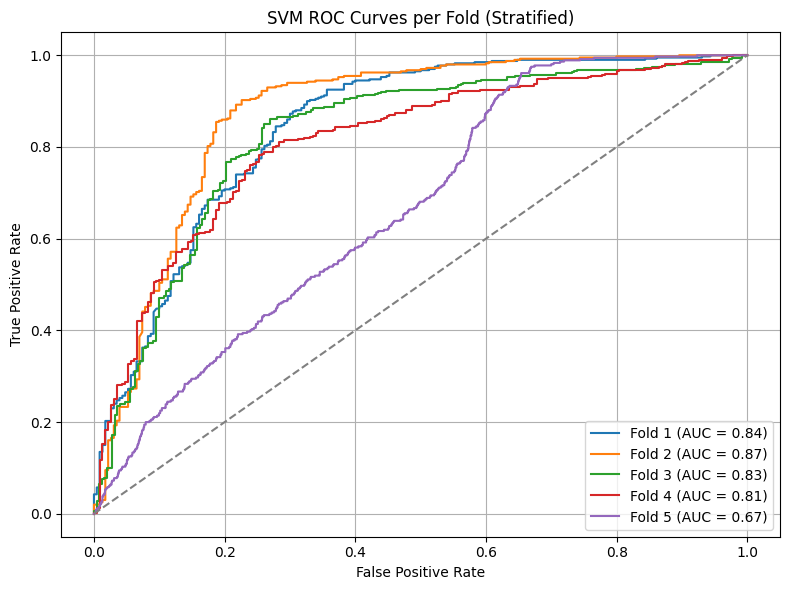

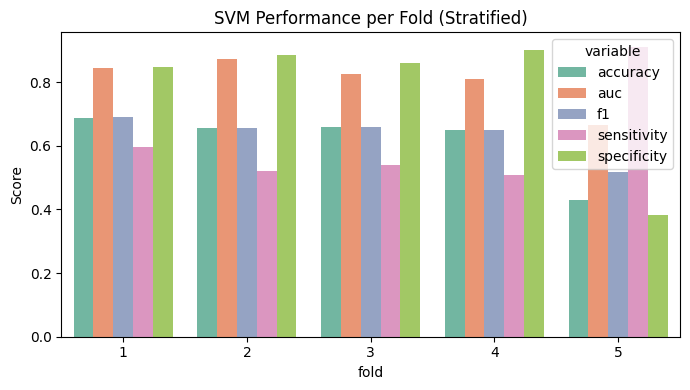

📁 All plots saved to /content/drive/MyDrive/PCGITA_MODELS/models_svm/SVM_plots


In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, recall_score
)
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/models_svm"
PLOT_DIR = os.path.join(MODEL_DIR, "SVM_plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]

# -------------------- FEATURES & TARGET --------------------
X = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y = df["Label"].map({"PD": 1, "HC": 0})
groups = df["Speaker_ID"]

# -------------------- STRATIFIED GROUP K-FOLD --------------------
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
all_metrics = []
roc_data = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\n Fold {fold + 1}/5")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # --- Train SVM ---
    model = SVC(
        kernel="rbf",
        C=10.0,
        gamma=0.01,
        probability=True,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)

    # --- Predict ---
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    try:
        auc_score = roc_auc_score(y_val, y_prob)
    except ValueError:
        auc_score = float('nan')
        print(" AUC not defined for this fold.")

    # Sensitivity (PD), Specificity (HC)
    sensitivity = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
    specificity = recall_score(y_val, y_pred, pos_label=0, zero_division=0)

    f1 = classification_report(y_val, y_pred, output_dict=True, zero_division=0)["weighted avg"]["f1-score"]

    print(f" Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

    # Save model
    model_path = os.path.join(MODEL_DIR, f"svm_fold{fold + 1}_stratified.joblib")
    joblib.dump(model, model_path)

    # Save metrics
    metrics = {
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc_score,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity
    }
    all_metrics.append(metrics)

    # Save ROC data
    if not np.isnan(auc_score):
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_data.append((fold + 1, fpr, tpr, auc_score))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/conf_matrix_fold{fold + 1}.png")
    plt.close()

# -------------------- SAVE METRICS --------------------
metrics_df = pd.DataFrame(all_metrics)
metrics_csv_path = os.path.join(MODEL_DIR, "svm_metrics_stratified.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n Metrics saved to {metrics_csv_path}")

# -------------------- ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, auc_score in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("SVM ROC Curves per Fold (Stratified)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_roc_curves_stratified.png")
plt.show()

# -------------------- SUMMARY BARPLOT --------------------
plt.figure(figsize=(7, 4))
sns.barplot(data=metrics_df.melt(id_vars="fold"),
            x="fold", y="value", hue="variable", palette="Set2")
plt.title("SVM Performance per Fold (Stratified)")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_performance_summary_stratified.png")
plt.show()

print(f" All plots saved to {PLOT_DIR}")


## SVM Hyperparameter Optimization with Feature Selection

This notebook explores various SVM configurations for Parkinson's disease detection using acoustic features, optimized via SelectKBest feature selection and 10-fold StratifiedGroupKFold validation.

###  Settings
- **Feature Selection**: Top 30 features selected with ANOVA F-score
- **Cross-Validation**: 10-fold StratifiedGroupKFold
- **Classifier**: SVC (Support Vector Classifier)
- **Hyperparameter Grid**:
  - RBF kernel: `C=1.0`, `gamma=0.01`
  - RBF kernel: `C=10.0`, `gamma=0.01`
  - Linear kernel: `C=1.0`

###  Evaluation Metrics
For each configuration and fold, the following were computed:
- Accuracy
- ROC AUC
- F1-score
- Sensitivity (PD recall)
- Specificity (HC recall)

###  Outputs
Each configuration saves:
- Models: `svm_fold{n}_{config}.joblib`
- Metrics: `svm_metrics_{config}.csv`
- Confusion matrix plots: `conf_matrix_fold{n}_{config}.png`
- ROC curves: `roc_curves_{config}.png`
- Summary barplots: `performance_barplot_{config}.png`


In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, classification_report,
    confusion_matrix, roc_curve
)
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/models_svm_optimized"
PLOT_DIR = os.path.join(MODEL_DIR, "SVM_plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]
X_all = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y_all = df["Label"].map({"PD": 1, "HC": 0})
groups_all = df["Speaker_ID"]

# -------------------- CONFIG --------------------
N_FEATURES = 30   # Select top 30 features
K_FOLDS = 10      # Increase folds for stability
SEED = 42
HYPERPARAMS = [
    {"kernel": "rbf", "C": 1.0, "gamma": 0.01},
    {"kernel": "rbf", "C": 10.0, "gamma": 0.01},
    {"kernel": "linear", "C": 1.0}
]

# -------------------- RUN EACH PARAM COMBINATION --------------------
for config in HYPERPARAMS:
    suffix = f"{config['kernel']}_C{config['C']}_g{config.get('gamma', 'NA')}"
    print(f"\n Testing config: {suffix}")

    gkf = StratifiedGroupKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
    all_metrics = []
    roc_data = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
        print(f"\n🔁 Fold {fold + 1}/{K_FOLDS}")

        # Split
        X_train_raw, X_val_raw = X_all.iloc[train_idx], X_all.iloc[val_idx]
        y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

        # SelectKBest (fit on training only)
        selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
        X_train = selector.fit_transform(X_train_raw, y_train)
        X_val = selector.transform(X_val_raw)

        # Init SVM
        model = SVC(
            kernel=config["kernel"],
            C=config["C"],
            gamma=config.get("gamma", "scale"),
            probability=True,
            class_weight="balanced",
            random_state=SEED
        )
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_prob)
        f1 = classification_report(y_val, y_pred, output_dict=True, zero_division=0)["weighted avg"]["f1-score"]
        sensitivity = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        specificity = recall_score(y_val, y_pred, pos_label=0, zero_division=0)

        print(f" Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

        # Save model
        model_path = os.path.join(MODEL_DIR, f"svm_fold{fold + 1}_{suffix}.joblib")
        joblib.dump(model, model_path)

        # Save metrics
        all_metrics.append({
            "fold": fold + 1,
            "accuracy": acc,
            "auc": auc_score,
            "f1": f1,
            "sensitivity": sensitivity,
            "specificity": specificity
        })

        # ROC
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_data.append((fold + 1, fpr, tpr, auc_score))

        # Confusion Matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
        plt.title(f"Confusion - Fold {fold + 1} ({suffix})")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f"conf_matrix_fold{fold + 1}_{suffix}.png"))
        plt.close()

    # Save all metrics
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(os.path.join(MODEL_DIR, f"svm_metrics_{suffix}.csv"), index=False)

    # ROC Plot
    plt.figure(figsize=(8, 6))
    for fold, fpr, tpr, auc_score in roc_data:
        plt.plot(fpr, tpr, label=f"Fold {fold} (AUC={auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"SVM ROC - {suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"roc_curves_{suffix}.png"))
    plt.close()

    # Summary Barplot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=metrics_df.melt(id_vars="fold"), x="fold", y="value", hue="variable")
    plt.title(f"SVM Scores - {suffix}")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"performance_barplot_{suffix}.png"))
    plt.close()

    print(f" Saved: models, metrics, plots for {suffix}")



🧪 Testing config: rbf_C1.0_g0.01

🔁 Fold 1/10
✅ Acc: 0.7090 | AUC: 0.8530 | Sens: 0.62 | Spec: 0.87

🔁 Fold 2/10
✅ Acc: 0.8349 | AUC: 0.9271 | Sens: 0.81 | Spec: 0.88

🔁 Fold 3/10
✅ Acc: 0.7111 | AUC: 0.8608 | Sens: 0.62 | Spec: 0.86

🔁 Fold 4/10
✅ Acc: 0.6847 | AUC: 0.8029 | Sens: 0.61 | Spec: 0.81

🔁 Fold 5/10
✅ Acc: 0.7968 | AUC: 0.8872 | Sens: 0.80 | Spec: 0.80

🔁 Fold 6/10
✅ Acc: 0.7619 | AUC: 0.8478 | Sens: 0.73 | Spec: 0.82

🔁 Fold 7/10
✅ Acc: 0.8349 | AUC: 0.8942 | Sens: 0.90 | Spec: 0.73

🔁 Fold 8/10
✅ Acc: 0.7556 | AUC: 0.8780 | Sens: 0.69 | Spec: 0.86

🔁 Fold 9/10
✅ Acc: 0.7016 | AUC: 0.8379 | Sens: 0.60 | Spec: 0.87

🔁 Fold 10/10
✅ Acc: 0.3776 | AUC: 0.6667 | Sens: 0.89 | Spec: 0.35
📁 Saved: models, metrics, plots for rbf_C1.0_g0.01

🧪 Testing config: rbf_C10.0_g0.01

🔁 Fold 1/10
✅ Acc: 0.6746 | AUC: 0.8182 | Sens: 0.56 | Spec: 0.88

🔁 Fold 2/10
✅ Acc: 0.7873 | AUC: 0.9042 | Sens: 0.73 | Spec: 0.89

🔁 Fold 3/10
✅ Acc: 0.6730 | AUC: 0.8571 | Sens: 0.56 | Spec: 0.87

🔁 Fold 

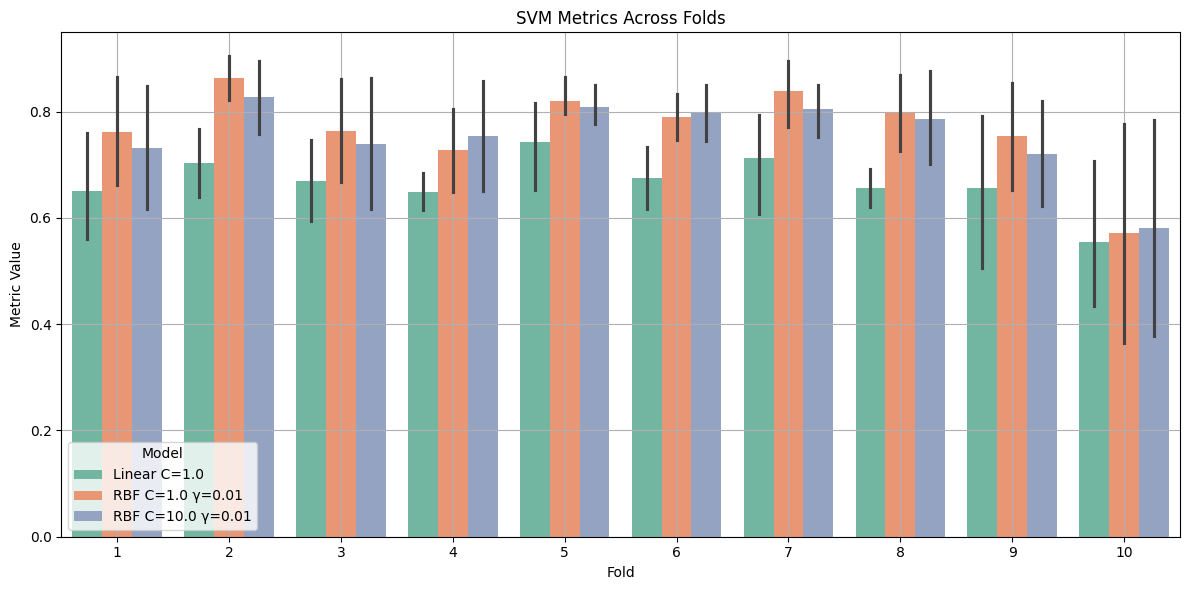

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load metrics
linear = pd.read_csv("/content/drive/MyDrive/PCGITA_MODELS/models_svm_optimized/svm_metrics_linear_C1.0_gNA.csv")
rbf1 = pd.read_csv("/content/drive/MyDrive/PCGITA_MODELS/models_svm_optimized/svm_metrics_rbf_C1.0_g0.01.csv")
rbf10 = pd.read_csv("/content/drive/MyDrive/PCGITA_MODELS/models_svm_optimized/svm_metrics_rbf_C10.0_g0.01.csv")

# Add labels
linear["Model"] = "Linear C=1.0"
rbf1["Model"] = "RBF C=1.0 γ=0.01"
rbf10["Model"] = "RBF C=10.0 γ=0.01"

# Merge all
df_all = pd.concat([linear, rbf1, rbf10])

# Save confusion matrices if available
def plot_confusion_matrix(cm, title, save_path):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["HC", "PD"], yticklabels=["HC", "PD"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Metric barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all.melt(id_vars=["fold", "Model"], value_vars=["accuracy", "auc", "sensitivity", "specificity"]),
            x="fold", y="value", hue="Model", palette="Set2")
plt.title("SVM Metrics Across Folds")
plt.xlabel("Fold")
plt.ylabel("Metric Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/PCGITA_MODELS/models_svm/svm_foldwise_metrics.png")
plt.show()


**Random FOREST**

## Random Forest Classification for Parkinson’s Detection

This notebook applies a Random Forest classifier on acoustic features to distinguish between Parkinson’s Disease (PD) and Healthy Control (HC) subjects.

###  Model Configuration
- **Classifier**: Random Forest
- **Cross-validation**: StratifiedGroupKFold (10 folds)
- **Feature selection**: Top 30 features using `SelectKBest(f_classif)`
- **Hyperparameters**:
  - `n_estimators=300`
  - `max_depth=10`
  - `min_samples_split=5`
  - `min_samples_leaf=2`
  - `class_weight="balanced"`

###  Input Features
- MFCCs (1–39)
- Jitter, shimmer, pitch
- Formants (F1–F3)
- Spectral features (centroid, bandwidth, rolloff, flatness)

###  Metrics Evaluated Per Fold
- Accuracy
- AUC (Area Under ROC Curve)
- Sensitivity (Recall of PD class)
- Specificity (Recall of HC class)
- F1-score

###  Outputs
- Models saved per fold: `rf_fold{n}.joblib`
- Metrics: `rf_metrics.csv`
- Confusion matrices: `conf_matrix_fold{n}.png`
- ROC curves: `roc_curves_rf.png`
- Summary performance: `performance_barplot_rf.png`


In [ ]:
# -------------------- SETUP --------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, classification_report,
    confusion_matrix, roc_curve
)
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/models_rf"
PLOT_DIR = os.path.join(MODEL_DIR, "RF_plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]
X_all = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y_all = df["Label"].map({"PD": 1, "HC": 0})
groups_all = df["Speaker_ID"]

# -------------------- CONFIG --------------------
N_FEATURES = 30
K_FOLDS = 10
SEED = 42
rf_params = {
    "n_estimators": 300,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "class_weight": "balanced",
    "random_state": SEED,
    "n_jobs": -1
}

# -------------------- CROSS-VALIDATION --------------------
print(f"\n🧪 Training Random Forest with 10-fold StratifiedGroupKFold")
gkf = StratifiedGroupKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
all_metrics = []
roc_data = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    print(f"\n Fold {fold + 1}/{K_FOLDS}")

    # Split
    X_train_raw, X_val_raw = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

    # SelectKBest
    selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
    X_train = selector.fit_transform(X_train_raw, y_train)
    X_val = selector.transform(X_val_raw)

    # Init RF
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc_score = roc_auc_score(y_val, y_prob)
    f1 = classification_report(y_val, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    sensitivity = recall_score(y_val, y_pred, pos_label=1)
    specificity = recall_score(y_val, y_pred, pos_label=0)

    print(f" Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

    # Save model
    model_path = os.path.join(MODEL_DIR, f"rf_fold{fold + 1}.joblib")
    joblib.dump(model, model_path)

    # Save metrics
    all_metrics.append({
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc_score,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity
    })

    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_data.append((fold + 1, fpr, tpr, auc_score))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Confusion - Fold {fold + 1}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"conf_matrix_fold{fold + 1}.png"))
    plt.close()

# -------------------- SAVE METRICS + PLOTS --------------------
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv(os.path.join(MODEL_DIR, "rf_metrics.csv"), index=False)

# ROC Plot
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, auc_score in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC={auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Random Forest ROC across folds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "roc_curves_rf.png"))
plt.close()

# Summary Barplot
plt.figure(figsize=(7, 4))
sns.barplot(data=metrics_df.melt(id_vars="fold"), x="fold", y="value", hue="variable")
plt.title("Random Forest Metrics Across Folds")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "performance_barplot_rf.png"))
plt.close()

print(" Random Forest training complete. Outputs saved.")



🧪 Training Random Forest with 10-fold StratifiedGroupKFold

🔁 Fold 1/10
✅ Acc: 0.6111 | AUC: 0.9185 | Sens: 0.41 | Spec: 0.96

🔁 Fold 2/10
✅ Acc: 0.7619 | AUC: 0.9440 | Sens: 0.66 | Spec: 0.95

🔁 Fold 3/10
✅ Acc: 0.6635 | AUC: 0.9007 | Sens: 0.53 | Spec: 0.90

🔁 Fold 4/10
✅ Acc: 0.6815 | AUC: 0.9182 | Sens: 0.54 | Spec: 0.93

🔁 Fold 5/10
✅ Acc: 0.7905 | AUC: 0.9248 | Sens: 0.73 | Spec: 0.89

🔁 Fold 6/10
✅ Acc: 0.7429 | AUC: 0.9255 | Sens: 0.64 | Spec: 0.93

🔁 Fold 7/10
✅ Acc: 0.8413 | AUC: 0.9331 | Sens: 0.82 | Spec: 0.88

🔁 Fold 8/10
✅ Acc: 0.6857 | AUC: 0.9264 | Sens: 0.54 | Spec: 0.95

🔁 Fold 9/10
✅ Acc: 0.7048 | AUC: 0.9076 | Sens: 0.58 | Spec: 0.92

🔁 Fold 10/10
✅ Acc: 0.3782 | AUC: 0.6998 | Sens: 0.92 | Spec: 0.35
✅ Random Forest training complete. Outputs saved.


## Optimized Random Forest Training for Parkinson’s Classification

This notebook evaluates three Random Forest configurations for classifying Parkinson’s Disease (PD) using acoustic speech features. Each model is evaluated with 10-fold StratifiedGroupKFold cross-validation.

### Model Variants
We trained three models using the following parameter combinations:

| Model ID | n_estimators | max_depth | min_samples_split | min_samples_leaf |
|----------|--------------|-----------|--------------------|------------------|
| rf_n200_d8_s4_l2        | 200        | 8         | 4                  | 2                |
| rf_n300_d12_s3_l1       | 300        | 12        | 3                  | 1                |
| rf_n500_dNone_s2_l1     | 500        | None      | 2                  | 1                |

Each configuration uses:
- `class_weight="balanced"`
- `SelectKBest` to retain the top 30 features (based on ANOVA F-score)
- Cross-validation: StratifiedGroupKFold with 10 folds
- Feature types: MFCCs, jitter, shimmer, pitch, formants, spectral features

###  Metrics per Fold
- Accuracy
- AUC (Area Under ROC Curve)
- F1-Score
- Sensitivity (Recall of PD)
- Specificity (Recall of HC)

### Output per Configuration
- Trained models: `/models_rf_optimized/{suffix}_fold{n}.joblib`
- Metrics CSV: `{suffix}_metrics.csv`
- Confusion matrices: `conf_matrix_fold{n}_{suffix}.png`
- ROC plots: `roc_curves_{suffix}.png`
- Performance bar plots: `barplot_{suffix}.png`


In [ ]:
# -------------------- RANDOM FOREST OPTIMIZED --------------------

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, recall_score,
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = "/content/drive/MyDrive/PCGITA_MODELS/models_rf_optimized"
PLOT_DIR = os.path.join(MODEL_DIR, "plots")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]
X_all = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y_all = df["Label"].map({"PD": 1, "HC": 0})
groups_all = df["Speaker_ID"]

# -------------------- CONFIG --------------------
N_FEATURES = 30
K_FOLDS = 10
SEED = 42

# Grid of parameter setups
CONFIGS = [
    {"n_estimators": 200, "max_depth": 8, "min_samples_split": 4, "min_samples_leaf": 2},
    {"n_estimators": 300, "max_depth": 12, "min_samples_split": 3, "min_samples_leaf": 1},
    {"n_estimators": 500, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
]

for idx, params in enumerate(CONFIGS):
    suffix = f"rf_n{params['n_estimators']}_d{params['max_depth']}_s{params['min_samples_split']}_l{params['min_samples_leaf']}"
    print(f"\n Training: {suffix}")

    all_metrics = []
    roc_data = []

    gkf = StratifiedGroupKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X_all, y_all, groups_all), start=1):
        print(f" Fold {fold}/{K_FOLDS}")

        X_train_raw, X_val_raw = X_all.iloc[train_idx], X_all.iloc[val_idx]
        y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

        # SelectKBest
        selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
        X_train = selector.fit_transform(X_train_raw, y_train)
        X_val = selector.transform(X_val_raw)

        model = RandomForestClassifier(
            **params,
            class_weight="balanced",
            random_state=SEED,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_prob)
        f1 = f1_score(y_val, y_pred)
        sensitivity = recall_score(y_val, y_pred, pos_label=1)
        specificity = recall_score(y_val, y_pred, pos_label=0)

        print(f" Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

        # Save model
        model_path = os.path.join(MODEL_DIR, f"{suffix}_fold{fold}.joblib")
        joblib.dump(model, model_path)

        # Save metrics
        all_metrics.append({
            "fold": fold,
            "accuracy": acc,
            "auc": auc_score,
            "f1": f1,
            "sensitivity": sensitivity,
            "specificity": specificity
        })

        # Save confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
        plt.title(f"Confusion - Fold {fold} ({suffix})")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f"conf_matrix_fold{fold}_{suffix}.png"))
        plt.close()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_data.append((fold, fpr, tpr, auc_score))

    # Save all fold metrics
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(os.path.join(MODEL_DIR, f"{suffix}_metrics.csv"), index=False)

    # Plot ROC
    plt.figure(figsize=(8, 6))
    for fold, fpr, tpr, auc_score in roc_data:
        plt.plot(fpr, tpr, label=f"Fold {fold} (AUC={auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC - {suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"roc_curves_{suffix}.png"))
    plt.close()

    # Plot barplot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=metrics_df.melt(id_vars="fold"), x="fold", y="value", hue="variable")
    plt.title(f"Performance - {suffix}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"barplot_{suffix}.png"))
    plt.close()

    print(f" Saved models, plots, and metrics for {suffix}")



🧪 Training: rf_n200_d8_s4_l2
🔁 Fold 1/10
✅ Acc: 0.6931 | AUC: 0.9159 | Sens: 0.55 | Spec: 0.93
🔁 Fold 2/10
✅ Acc: 0.7937 | AUC: 0.9443 | Sens: 0.70 | Spec: 0.96
🔁 Fold 3/10
✅ Acc: 0.7079 | AUC: 0.9005 | Sens: 0.60 | Spec: 0.90
🔁 Fold 4/10
✅ Acc: 0.7420 | AUC: 0.9206 | Sens: 0.64 | Spec: 0.92
🔁 Fold 5/10
✅ Acc: 0.8032 | AUC: 0.9216 | Sens: 0.77 | Spec: 0.87
🔁 Fold 6/10
✅ Acc: 0.7746 | AUC: 0.9215 | Sens: 0.69 | Spec: 0.93
🔁 Fold 7/10
✅ Acc: 0.8413 | AUC: 0.9326 | Sens: 0.83 | Spec: 0.85
🔁 Fold 8/10
✅ Acc: 0.7651 | AUC: 0.9229 | Sens: 0.68 | Spec: 0.92
🔁 Fold 9/10
✅ Acc: 0.7302 | AUC: 0.9144 | Sens: 0.62 | Spec: 0.91
🔁 Fold 10/10
✅ Acc: 0.3858 | AUC: 0.6982 | Sens: 0.93 | Spec: 0.36
📊 Saved models, plots, and metrics for rf_n200_d8_s4_l2

🧪 Training: rf_n300_d12_s3_l1
🔁 Fold 1/10
✅ Acc: 0.5582 | AUC: 0.9180 | Sens: 0.32 | Spec: 0.98
🔁 Fold 2/10
✅ Acc: 0.6825 | AUC: 0.9418 | Sens: 0.51 | Spec: 0.98
🔁 Fold 3/10
✅ Acc: 0.6000 | AUC: 0.9003 | Sens: 0.41 | Spec: 0.93
🔁 Fold 4/10
✅ Acc: 0.652

##  Logistic Regression with Multi-Solver Grid Search (10-fold CV)

This notebook trains a Logistic Regression model for binary classification (PD vs HC) using extracted acoustic features. A 10-fold StratifiedGroupKFold cross-validation is employed to avoid speaker leakage and ensure label balance across folds.

###  Pipeline Steps
- Feature scaling with `StandardScaler`
- Top 30 feature selection via `SelectKBest(f_classif)`
- Logistic Regression model with `class_weight='balanced'`

###  Hyperparameter Grid
Evaluated using `GridSearchCV` (3-fold internal CV):

- **C**: `[0.01, 0.1, 1, 10]`
- **Penalty**: `['l1', 'l2']`
- **Solver**: `['liblinear', 'lbfgs', 'saga']`
- Invalid combinations (e.g., `lbfgs` + `l1`) are excluded.

###  Fold-wise Outputs
- Best parameter combination per fold
- Metrics: Accuracy, AUC, F1-score, Sensitivity, Specificity
- Plots: Confusion matrix, ROC curves, performance barplot

###  Output Files
- `logreg_fold{n}.joblib`: Trained model for each fold
- `logreg_metrics_solvers.csv`: All performance metrics
- `roc_curves_logreg_solvers.png`
- `performance_barplot_logreg_solvers.png`
- `conf_matrix_fold{n}.png`: Per-fold confusion matrix


In [ ]:
# -------------------- SETUP --------------------
import os
import joblib
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, classification_report,
    confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- PATHS --------------------
FEATURES_CSV = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = Path("/content/drive/MyDrive/PCGITA_MODELS/models_logreg")
PLOT_DIR = MODEL_DIR / "LogReg_plots"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- CONFIG --------------------
N_FEATURES = 30
K_FOLDS = 10
SEED = 42

# Valid parameter combinations (wrapped in lists)
param_grid = [
    {"clf__C": [c], "clf__penalty": [p], "clf__solver": [s]}
    for c in [0.01, 0.1, 1, 10]
    for p, s in [("l2", "lbfgs"), ("l2", "saga"), ("l1", "liblinear"), ("l1", "saga")]
]

# -------------------- LOAD DATA --------------------
df = pd.read_csv(FEATURES_CSV)
df = df[df["Label"].isin(["PD", "HC"])]
X_all = df.filter(regex="mfcc|jitter|shimmer|formant|pitch|spectral", axis=1)
y_all = df["Label"].map({"PD": 1, "HC": 0})
groups_all = df["Speaker_ID"]

# -------------------- CROSS-VALIDATION --------------------
print(f"\n Training Logistic Regression with multi-solver GridSearch and {K_FOLDS}-fold StratifiedGroupKFold")
gkf = StratifiedGroupKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
all_metrics, roc_data = [], []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_all, y_all, groups_all)):
    print(f"\n Fold {fold + 1}/{K_FOLDS}")
    X_train_raw, X_val_raw = X_all.iloc[train_idx], X_all.iloc[val_idx]
    y_train, y_val = y_all.iloc[train_idx], y_all.iloc[val_idx]

    # Pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=N_FEATURES)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED))
    ])

    # GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=3, error_score='raise')
    try:
        grid.fit(X_train_raw, y_train)
    except ValueError as e:
        print(f" GridSearch failed on fold {fold + 1}: {e}")
        continue

    best_params = grid.best_params_
    print(f" Best Params: {best_params}")

    model = grid.best_estimator_
    y_pred = model.predict(X_val_raw)
    y_prob = model.predict_proba(X_val_raw)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    try:
        auc_score = roc_auc_score(y_val, y_prob)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_data.append((fold + 1, fpr, tpr, auc_score))
    except ValueError:
        auc_score = np.nan

    f1 = classification_report(y_val, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    sensitivity = recall_score(y_val, y_pred, pos_label=1)
    specificity = recall_score(y_val, y_pred, pos_label=0)

    print(f" Fold {fold + 1} → Acc: {acc:.4f} | AUC: {auc_score:.4f} | Sens: {sensitivity:.2f} | Spec: {specificity:.2f}")

    # Save model
    joblib.dump(model, MODEL_DIR / f"logreg_fold{fold + 1}.joblib")

    all_metrics.append({
    "fold": fold + 1,
    "accuracy": acc,
    "auc": auc_score,
    "f1": f1,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "C": best_params["clf__C"],
    "penalty": best_params["clf__penalty"],
    "solver": best_params["clf__solver"]
    })


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.tight_layout()
    plt.savefig(PLOT_DIR / f"conf_matrix_fold{fold + 1}.png")
    plt.close()

# -------------------- SAVE METRICS + PLOTS --------------------
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.to_csv(MODEL_DIR / "logreg_metrics_solvers.csv", index=False)

    # ROC Curves
    if roc_data:
        plt.figure(figsize=(8, 6))
        for fold, fpr, tpr, auc_score in roc_data:
            plt.plot(fpr, tpr, label=f"Fold {fold} (AUC={auc_score:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("ROC Curves across folds (Logistic Regression)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.savefig(PLOT_DIR / "roc_curves_logreg_solvers.png")
        plt.close()

    # Metrics Barplot
    metric_cols = ["accuracy", "auc", "f1", "sensitivity", "specificity"]
    if all(col in metrics_df.columns for col in metric_cols):
        plt.figure(figsize=(10, 5))
        sns.barplot(data=metrics_df.melt(id_vars="fold", value_vars=metric_cols),
                    x="fold", y="value", hue="variable")
        plt.title("Logistic Regression Metrics Across Folds")
        plt.ylabel("Score")
        plt.tight_layout()
        plt.savefig(PLOT_DIR / "performance_barplot_logreg_solvers.png")
        plt.close()

    print("\n Logistic Regression training complete. Outputs saved.")
else:
    print("\n No folds completed successfully.")



🧪 Training Logistic Regression with multi-solver GridSearch and 10-fold StratifiedGroupKFold

🔁 Fold 1/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
📊 Fold 1 → Acc: 0.6217 | AUC: 0.6910 | Sens: 0.53 | Spec: 0.79

🔁 Fold 2/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
📊 Fold 2 → Acc: 0.6730 | AUC: 0.7763 | Sens: 0.64 | Spec: 0.73

🔁 Fold 3/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
📊 Fold 3 → Acc: 0.6190 | AUC: 0.6815 | Sens: 0.53 | Spec: 0.77

🔁 Fold 4/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
📊 Fold 4 → Acc: 0.5955 | AUC: 0.6814 | Sens: 0.54 | Spec: 0.69

🔁 Fold 5/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
📊 Fold 5 → Acc: 0.7429 | AUC: 0.8115 | Sens: 0.82 | Spec: 0.61

🔁 Fold 6/10
✅ Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
📊 Fold 6 → Acc: 0.6317 | AUC: 0.7062 | Sens: 0.58 | Spec: 0.

## XGBoost Classifier for PD Detection (5-Fold GroupKFold)

This notebook implements a speaker-independent binary classifier using `XGBoost` to distinguish Parkinson’s Disease (PD) from healthy controls (HC). It uses speech-derived acoustic features with a GroupKFold strategy to avoid speaker overlap across training and validation.

### Configuration
- **Model**: `XGBClassifier`
- **Features**: MFCCs, jitter, shimmer, formants, pitch, spectral features
- **CV Strategy**: 5-Fold `GroupKFold` (to avoid speaker leakage)
- **Hyperparameters**:
  - `n_estimators=200`
  - `learning_rate=0.05`
  - `max_depth=5`
  - `subsample=0.8`, `colsample_bytree=0.8`

### Evaluation Metrics
- Accuracy, AUC (ROC), F1-score
- Confusion matrix (per fold & combined)
- ROC curves (per fold)
- Top 15 features by importance
- Final `VotingClassifier` ensemble trained on all data

### Output Files
- Trained models: `xgb_fold{n}.joblib`
- Ensemble: `xgb_voting_model.joblib`
- Metrics: `xgb_metrics.csv`
- Predictions: `xgb_fold_predictions.csv`
- Plots:
  - `xgb_roc_curves.png`
  - `confusion_matrix_fold{n}.png`
  - `confusion_matrix_combined.png`
  - `xgb_feature_importance.png`


In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from joblib import dump

# -------------------- PATHS --------------------
csv_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
output_dir = "/content/drive/MyDrive/PCGITA_MODELS/models_xgb"
os.makedirs(output_dir, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(csv_path)
df = df[df["Label"].isin(["PD", "HC"])]

# Features
exclude_cols = ["Label", "Speaker_ID", "Full_Path", "Task", "filename"]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype != "object"]
X = df[feature_cols].fillna(0).values
y = df["Label"].map({"HC": 0, "PD": 1}).values
groups = df["Speaker_ID"]

# -------------------- TRAINING --------------------
gkf = GroupKFold(n_splits=5)
models = []
roc_data = []
predictions = []
metrics = []

# For combined confusion matrix
combined_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
    print(f"\n Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=fold
    )
    model.fit(X_train, y_train)
    models.append(model)

    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f" Accuracy: {acc:.4f} | AUC: {roc_auc:.4f}")
    print(classification_report(y_val, y_pred))

    # Save fold predictions
    fold_preds = pd.DataFrame({
        "fold": fold,
        "speaker_id": df.iloc[val_idx]["Speaker_ID"].values,
        "true_label": y_val,
        "pred_label": y_pred,
        "proba_PD": y_proba
    })
    predictions.append(fold_preds)

    # Save model
    model_path = os.path.join(output_dir, f"xgb_fold{fold}.joblib")
    dump(model, model_path)

    # Save ROC and metrics
    roc_data.append((fold, fpr, tpr, roc_auc))
    metrics.append({"fold": fold, "accuracy": acc, "auc": roc_auc})

    # Save normalized confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    combined_cm += cm

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Normalized Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    cm_path = os.path.join(output_dir, f"confusion_matrix_fold{fold}.png")
    plt.savefig(cm_path, dpi=300)
    plt.close()

# -------------------- COMBINED CONFUSION MATRIX --------------------
combined_cm_norm = combined_cm.astype("float") / combined_cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5, 4))
sns.heatmap(combined_cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Combined Normalized Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_combined.png"), dpi=300)
plt.close()

# -------------------- PLOT ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_roc_curves.png", dpi=300)
plt.close()

# -------------------- FEATURE IMPORTANCE --------------------
importances = pd.DataFrame()
for i, model in enumerate(models):
    importances[f"fold_{i+1}"] = model.feature_importances_
importances["feature"] = feature_cols
importances["mean_importance"] = importances.iloc[:, :-1].mean(axis=1)
top_feats = importances.sort_values("mean_importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")
plt.title("Top 15 Features (XGBoost)")
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_feature_importance.png", dpi=300)
plt.close()

# -------------------- VOTING ENSEMBLE --------------------
ensemble = VotingClassifier(
    estimators=[(f"xgb_{i}", m) for i, m in enumerate(models)],
    voting="soft"
)
ensemble.fit(X, y)
dump(ensemble, f"{output_dir}/xgb_voting_model.joblib")
print(" VotingClassifier ensemble saved.")

# -------------------- SAVE PREDICTIONS & METRICS --------------------
final_preds = pd.concat(predictions, ignore_index=True)
final_preds.to_csv(f"{output_dir}/xgb_fold_predictions.csv", index=False)

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"{output_dir}/xgb_metrics.csv", index=False)

print(" Saved predictions, metrics, and all plots.")



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

✅ Accuracy: 0.3645 | AUC: nan
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      3265
           1       0.00      0.00      0.00         0

    accuracy                           0.36      3265
   macro avg       0.50      0.18      0.27      3265
weighted avg       1.00      0.36      0.53      3265


🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9218 | AUC: 0.9710
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       299
           1       0.93      0.95      0.94       519

    accuracy                           0.92       818
   macro avg       0.92      0.91      0.91       818
weighted avg       0.92      0.92      0.92       818


🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8730 | AUC: 0.9489
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       276
           1       0.90      0.91      0.90       480

    accuracy                           0.87       756
   macro avg       0.86      0.86      0.86       756
weighted avg       0.87      0.87      0.87       756


🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9008 | AUC: 0.9692
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       276
           1       0.93      0.91      0.92       480

    accuracy                           0.90       756
   macro avg       0.89      0.90      0.89       756
weighted avg       0.90      0.90      0.90       756


🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.7528 | AUC: 0.8423
              precision    recall  f1-score   support

           0       0.61      0.93      0.73       299
           1       0.94      0.65      0.77       518

    accuracy                           0.75       817
   macro avg       0.77      0.79      0.75       817
weighted avg       0.82      0.75      0.76       817



/tmp/ipython-input-24-869032102.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:06:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:15

✅ VotingClassifier ensemble saved.
📄 Saved predictions, metrics, and all plots.



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


✅ Accuracy: 0.3645 | AUC: nan | Sensitivity: 0.0000 | Specificity: 0.3645


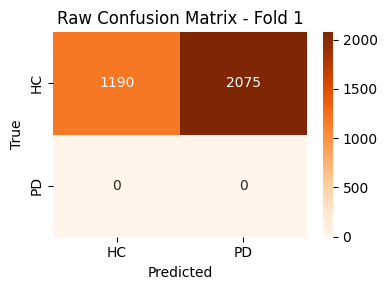


🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9218 | AUC: 0.9710 | Sensitivity: 0.9538 | Specificity: 0.8662


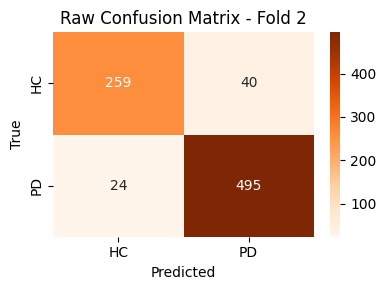


🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8730 | AUC: 0.9489 | Sensitivity: 0.9062 | Specificity: 0.8152


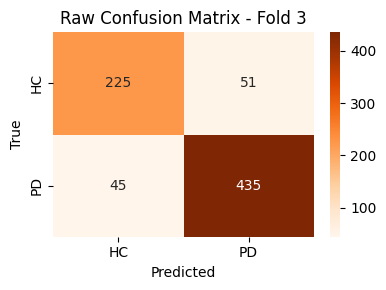


🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9008 | AUC: 0.9692 | Sensitivity: 0.9125 | Specificity: 0.8804


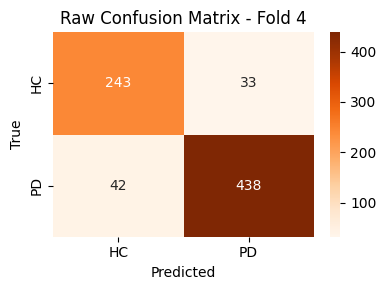


🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.7528 | AUC: 0.8423 | Sensitivity: 0.6525 | Specificity: 0.9264


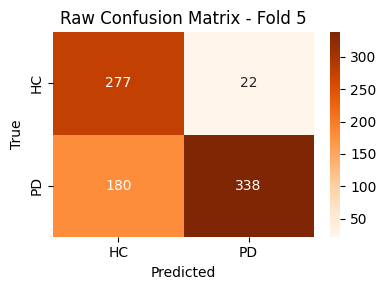

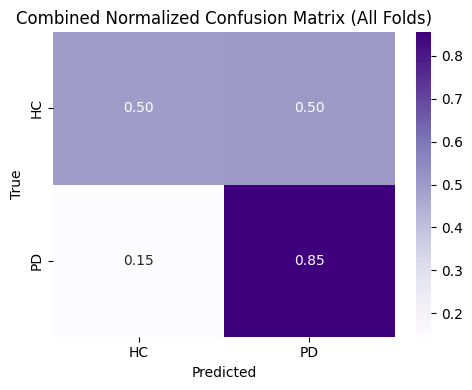

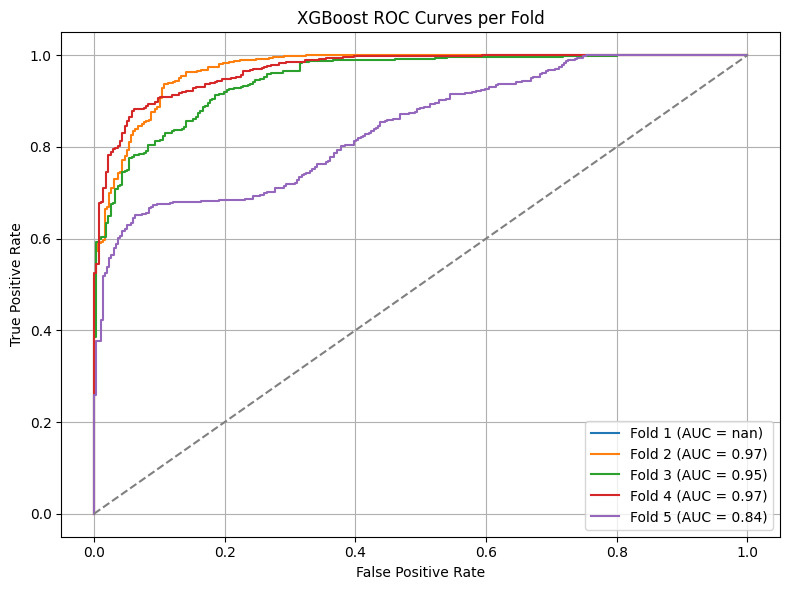

/tmp/ipython-input-25-2700779490.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")


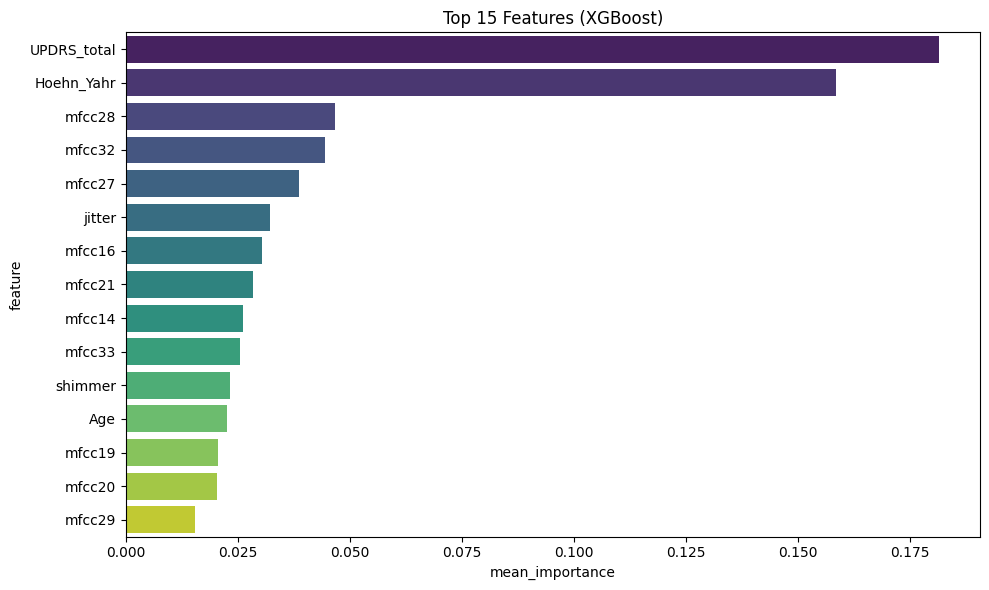

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ VotingClassifier ensemble saved.
📄 All predictions, metrics, confusion matrices, and plots saved.


In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, classification_report,
    confusion_matrix, recall_score, f1_score
)
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from joblib import dump

# -------------------- PATHS --------------------
csv_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
output_dir = "/content/drive/MyDrive/PCGITA_MODELS/models_xgb"
os.makedirs(output_dir, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(csv_path)
df = df[df["Label"].isin(["PD", "HC"])]

# Features
exclude_cols = ["Label", "Speaker_ID", "Full_Path", "Task", "filename"]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype != "object"]
X = df[feature_cols].fillna(0).values
y = df["Label"].map({"HC": 0, "PD": 1}).values
groups = df["Speaker_ID"]

# -------------------- TRAINING --------------------
gkf = GroupKFold(n_splits=5)
models = []
roc_data = []
predictions = []
metrics = []

# Combined confusion matrix
combined_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=fold
    )
    model.fit(X_train, y_train)
    models.append(model)

    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    sensitivity = recall_score(y_val, y_pred, pos_label=1)  # PD
    specificity = recall_score(y_val, y_pred, pos_label=0)  # HC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"✅ Accuracy: {acc:.4f} | AUC: {roc_auc:.4f} | Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")

    # Save fold predictions
    fold_preds = pd.DataFrame({
        "fold": fold,
        "speaker_id": df.iloc[val_idx]["Speaker_ID"].values,
        "true_label": y_val,
        "pred_label": y_pred,
        "proba_PD": y_proba
    })
    predictions.append(fold_preds)

    # Save model
    model_path = os.path.join(output_dir, f"xgb_fold{fold}.joblib")
    dump(model, model_path)

    # Save ROC and metrics
    roc_data.append((fold, fpr, tpr, roc_auc))
    metrics.append({
        "fold": fold,
        "accuracy": acc,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": roc_auc
    })

    # -------------------- CONFUSION MATRICES --------------------
    cm = confusion_matrix(y_val, y_pred)
    combined_cm += cm

    # Raw CM
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges",
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Raw Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_raw_fold{fold}.png"), dpi=300)
    plt.show()


# -------------------- COMBINED CONFUSION MATRIX --------------------
combined_cm_norm = combined_cm.astype("float") / combined_cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5, 4))
sns.heatmap(combined_cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Combined Normalized Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_combined.png"), dpi=300)
plt.show()

# -------------------- PLOT ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_roc_curves.png", dpi=300)
plt.show()

# -------------------- FEATURE IMPORTANCE --------------------
importances = pd.DataFrame()
for i, model in enumerate(models):
    importances[f"fold_{i+1}"] = model.feature_importances_
importances["feature"] = feature_cols
importances["mean_importance"] = importances.iloc[:, :-1].mean(axis=1)
top_feats = importances.sort_values("mean_importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")
plt.title("Top 15 Features (XGBoost)")
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_feature_importance.png", dpi=300)
plt.show()

# -------------------- VOTING ENSEMBLE --------------------
ensemble = VotingClassifier(
    estimators=[(f"xgb_{i}", m) for i, m in enumerate(models)],
    voting="soft"
)
ensemble.fit(X, y)
dump(ensemble, f"{output_dir}/xgb_voting_model.joblib")
print("✅ VotingClassifier ensemble saved.")

# -------------------- SAVE PREDICTIONS & METRICS --------------------
final_preds = pd.concat(predictions, ignore_index=True)
final_preds.to_csv(f"{output_dir}/xgb_fold_predictions.csv", index=False)

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"{output_dir}/xgb_metrics.csv", index=False)

print("📄 All predictions, metrics, confusion matrices, and plots saved.")



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/tmp/ipython-input-18-307839661.py:104: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


✅ Accuracy: 0.3645 | AUC: nan | Sensitivity: 0.0000 | Specificity: 0.3645


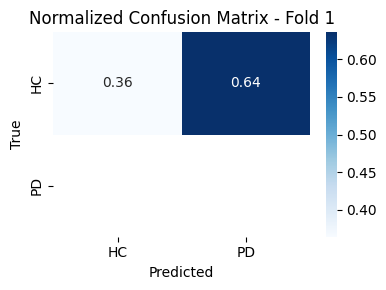


🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9218 | AUC: 0.9710 | Sensitivity: 0.9538 | Specificity: 0.8662


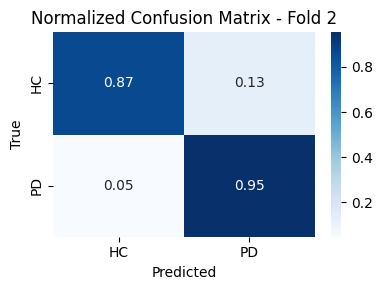


🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8730 | AUC: 0.9489 | Sensitivity: 0.9062 | Specificity: 0.8152


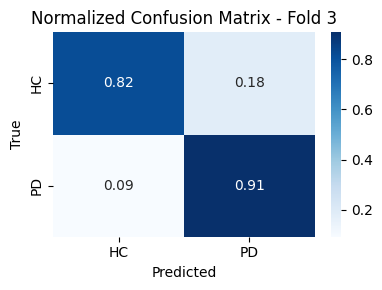


🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9008 | AUC: 0.9692 | Sensitivity: 0.9125 | Specificity: 0.8804


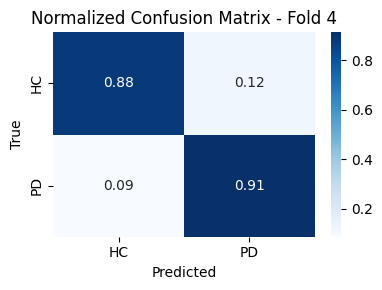


🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.7528 | AUC: 0.8423 | Sensitivity: 0.6525 | Specificity: 0.9264


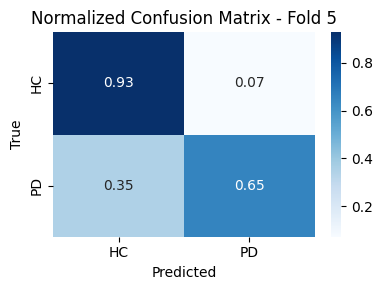

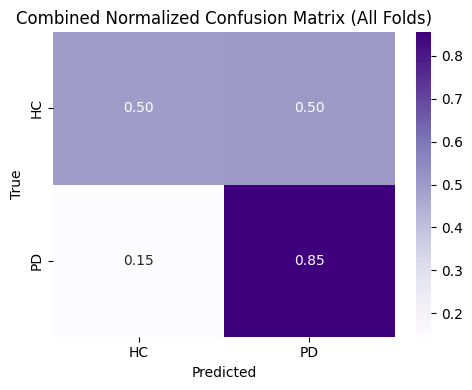

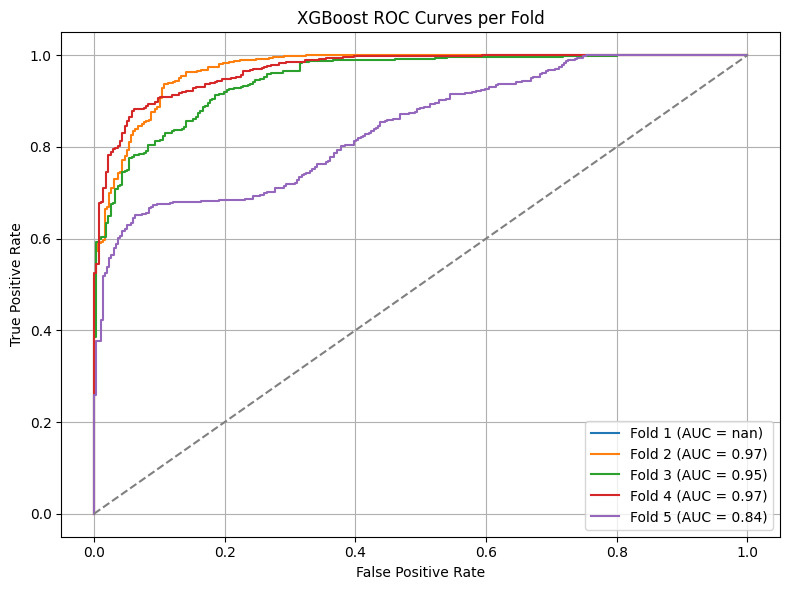

/tmp/ipython-input-18-307839661.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")


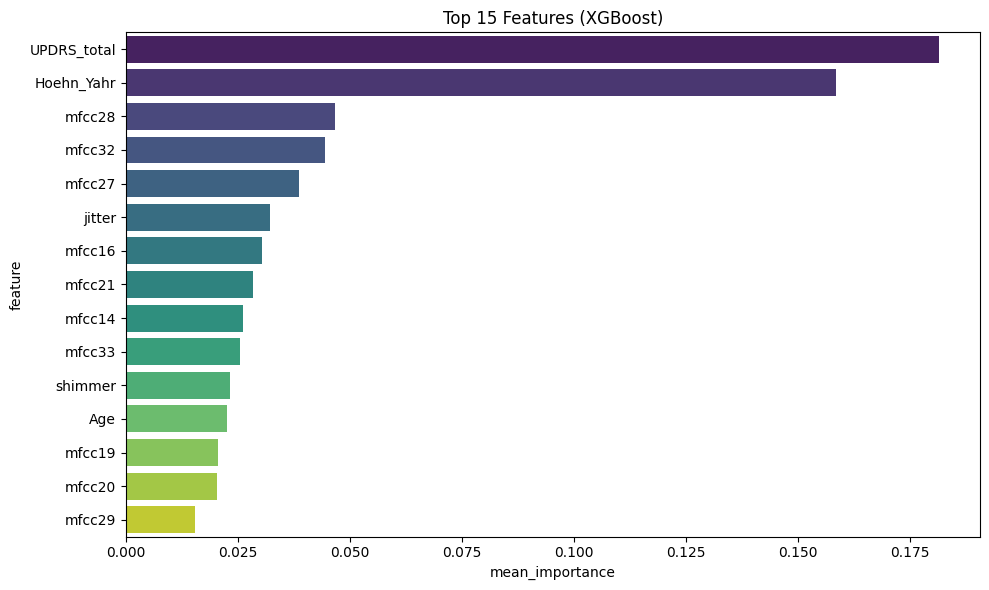

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ VotingClassifier ensemble saved.
📄 All predictions, metrics, confusion matrices, and plots saved.


In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, classification_report,
    confusion_matrix, recall_score, f1_score
)
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from joblib import dump

# -------------------- PATHS --------------------
csv_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
output_dir = "/content/drive/MyDrive/PCGITA_MODELS/models_xgb"
os.makedirs(output_dir, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(csv_path)
df = df[df["Label"].isin(["PD", "HC"])]

# Features
exclude_cols = ["Label", "Speaker_ID", "Full_Path", "Task", "filename"]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype != "object"]
X = df[feature_cols].fillna(0).values
y = df["Label"].map({"HC": 0, "PD": 1}).values
groups = df["Speaker_ID"]

# -------------------- TRAINING --------------------
gkf = GroupKFold(n_splits=5)
models = []
roc_data = []
predictions = []
metrics = []

# Combined confusion matrix
combined_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=fold
    )
    model.fit(X_train, y_train)
    models.append(model)

    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    sensitivity = recall_score(y_val, y_pred, pos_label=1)  # PD
    specificity = recall_score(y_val, y_pred, pos_label=0)  # HC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"✅ Accuracy: {acc:.4f} | AUC: {roc_auc:.4f} | Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")

    # Save fold predictions
    fold_preds = pd.DataFrame({
        "fold": fold,
        "speaker_id": df.iloc[val_idx]["Speaker_ID"].values,
        "true_label": y_val,
        "pred_label": y_pred,
        "proba_PD": y_proba
    })
    predictions.append(fold_preds)

    # Save model
    model_path = os.path.join(output_dir, f"xgb_fold{fold}.joblib")
    dump(model, model_path)

    # Save ROC and metrics
    roc_data.append((fold, fpr, tpr, roc_auc))
    metrics.append({
        "fold": fold,
        "accuracy": acc,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": roc_auc
    })

    # -------------------- SAVE NORMALIZED CONFUSION MATRIX --------------------
    cm = confusion_matrix(y_val, y_pred)
    combined_cm += cm

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Normalized Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_fold{fold}.png"), dpi=300)
    plt.show()

# -------------------- COMBINED CONFUSION MATRIX --------------------
combined_cm_norm = combined_cm.astype("float") / combined_cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5, 4))
sns.heatmap(combined_cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Combined Normalized Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_combined.png"), dpi=300)
plt.show()

# -------------------- PLOT ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_roc_curves.png", dpi=300)
plt.show()

# -------------------- FEATURE IMPORTANCE --------------------
importances = pd.DataFrame()
for i, model in enumerate(models):
    importances[f"fold_{i+1}"] = model.feature_importances_
importances["feature"] = feature_cols
importances["mean_importance"] = importances.iloc[:, :-1].mean(axis=1)
top_feats = importances.sort_values("mean_importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")
plt.title("Top 15 Features (XGBoost)")
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_feature_importance.png", dpi=300)
plt.show()

# -------------------- VOTING ENSEMBLE --------------------
ensemble = VotingClassifier(
    estimators=[(f"xgb_{i}", m) for i, m in enumerate(models)],
    voting="soft"
)
ensemble.fit(X, y)
dump(ensemble, f"{output_dir}/xgb_voting_model.joblib")
print("✅ VotingClassifier ensemble saved.")

# -------------------- SAVE PREDICTIONS & METRICS --------------------
final_preds = pd.concat(predictions, ignore_index=True)
final_preds.to_csv(f"{output_dir}/xgb_fold_predictions.csv", index=False)

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"{output_dir}/xgb_metrics.csv", index=False)

print("📄 All predictions, metrics, confusion matrices, and plots saved.")



🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/tmp/ipython-input-26-4254492964.py:108: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


✅ Accuracy: 0.3528 | AUC: nan | Sensitivity: 0.0000 | Specificity: 0.3528


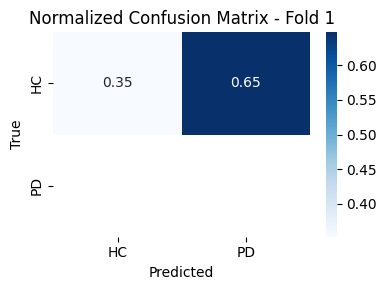


🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.9108 | AUC: 0.9690 | Sensitivity: 0.9480 | Specificity: 0.8462


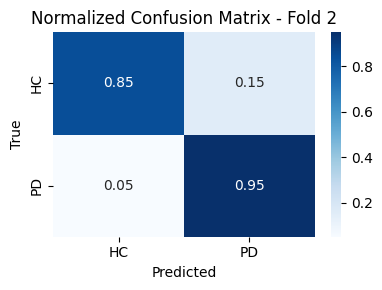


🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8690 | AUC: 0.9457 | Sensitivity: 0.9146 | Specificity: 0.7899


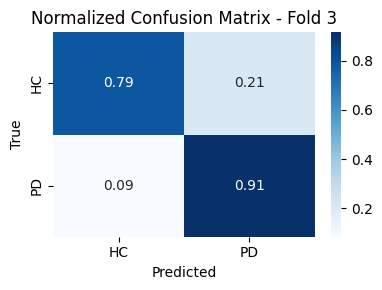


🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8995 | AUC: 0.9683 | Sensitivity: 0.9250 | Specificity: 0.8551


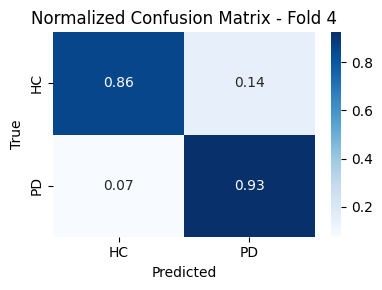


🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.7540 | AUC: 0.8873 | Sensitivity: 0.6564 | Specificity: 0.9231


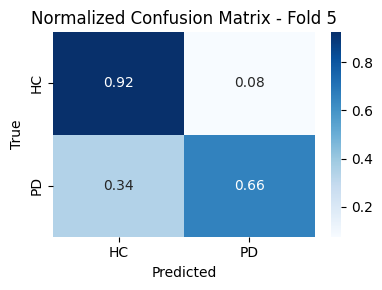

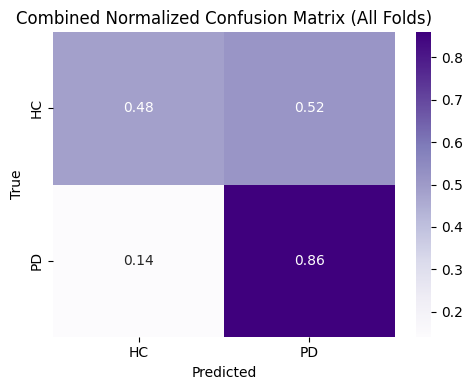

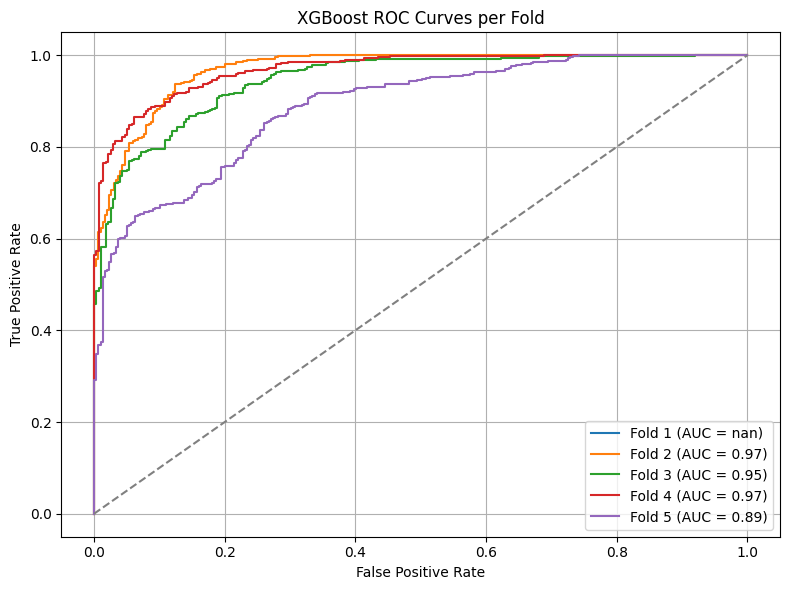

/tmp/ipython-input-26-4254492964.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")


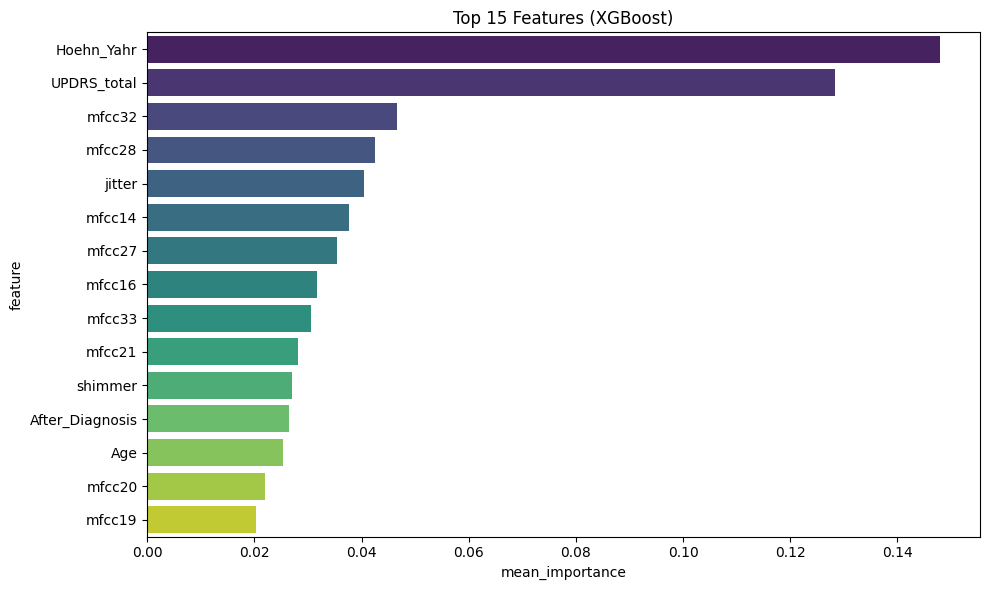

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ VotingClassifier ensemble saved.
📄 All predictions, metrics, confusion matrices, and plots saved.


In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, classification_report,
    confusion_matrix, recall_score, f1_score
)
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from joblib import dump

# -------------------- PATHS --------------------
csv_path = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_clean.csv"
output_dir = "/content/drive/MyDrive/PCGITA_MODELS/models_xgb"
os.makedirs(output_dir, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(csv_path)
df = df[df["Label"].isin(["PD", "HC"])]

# Features
exclude_cols = ["Label", "Speaker_ID", "Full_Path", "Task", "filename"]
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype != "object"]
X = df[feature_cols].fillna(0).values
y = df["Label"].map({"HC": 0, "PD": 1}).values
groups = df["Speaker_ID"]

# -------------------- TRAINING --------------------
gkf = GroupKFold(n_splits=5)
models = []
roc_data = []
predictions = []
metrics = []

# Combined confusion matrix
combined_cm = np.zeros((2, 2), dtype=int)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups), 1):
    print(f"\n🔁 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=1,
    reg_alpha=0.2,
    reg_lambda=2,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=fold
    )

    model.fit(X_train, y_train)
    models.append(model)

    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    sensitivity = recall_score(y_val, y_pred, pos_label=1)  # PD
    specificity = recall_score(y_val, y_pred, pos_label=0)  # HC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"✅ Accuracy: {acc:.4f} | AUC: {roc_auc:.4f} | Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f}")

    # Save fold predictions
    fold_preds = pd.DataFrame({
        "fold": fold,
        "speaker_id": df.iloc[val_idx]["Speaker_ID"].values,
        "true_label": y_val,
        "pred_label": y_pred,
        "proba_PD": y_proba
    })
    predictions.append(fold_preds)

    # Save model
    model_path = os.path.join(output_dir, f"xgb_fold{fold}.joblib")
    dump(model, model_path)

    # Save ROC and metrics
    roc_data.append((fold, fpr, tpr, roc_auc))
    metrics.append({
        "fold": fold,
        "accuracy": acc,
        "f1_score": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": roc_auc
    })

    # -------------------- SAVE NORMALIZED CONFUSION MATRIX --------------------
    cm = confusion_matrix(y_val, y_pred)
    combined_cm += cm

    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.title(f"Normalized Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"confusion_matrix_fold{fold}.png"), dpi=300)
    plt.show()

# -------------------- COMBINED CONFUSION MATRIX --------------------
combined_cm_norm = combined_cm.astype("float") / combined_cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5, 4))
sns.heatmap(combined_cm_norm, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
plt.title("Combined Normalized Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_combined.png"), dpi=300)
plt.show()

# -------------------- PLOT ROC CURVES --------------------
plt.figure(figsize=(8, 6))
for fold, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_roc_curves.png", dpi=300)
plt.show()

# -------------------- FEATURE IMPORTANCE --------------------
importances = pd.DataFrame()
for i, model in enumerate(models):
    importances[f"fold_{i+1}"] = model.feature_importances_
importances["feature"] = feature_cols
importances["mean_importance"] = importances.iloc[:, :-1].mean(axis=1)
top_feats = importances.sort_values("mean_importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_feats, x="mean_importance", y="feature", palette="viridis")
plt.title("Top 15 Features (XGBoost)")
plt.tight_layout()
plt.savefig(f"{output_dir}/xgb_feature_importance.png", dpi=300)
plt.show()

# -------------------- VOTING ENSEMBLE --------------------
ensemble = VotingClassifier(
    estimators=[(f"xgb_{i}", m) for i, m in enumerate(models)],
    voting="soft"
)
ensemble.fit(X, y)
dump(ensemble, f"{output_dir}/xgb_voting_model.joblib")
print("✅ VotingClassifier ensemble saved.")

# -------------------- SAVE PREDICTIONS & METRICS --------------------
final_preds = pd.concat(predictions, ignore_index=True)
final_preds.to_csv(f"{output_dir}/xgb_fold_predictions.csv", index=False)

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"{output_dir}/xgb_metrics.csv", index=False)

print("📄 All predictions, metrics, confusion matrices, and plots saved.")


#**UPDATED LOGISTIC REGRESSION**

In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_curve
)
import joblib
import shap
from pathlib import Path

# -------------------- PATHS --------------------
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = Path("/content/drive/MyDrive/PCGITA_MODELS/models_logreg/")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["Label"].isin(["PD", "HC"])]  # Keep valid classes
df = df.dropna()  # Drop rows with missing values

# -------------------- ENCODE LABELS --------------------
df["Label"] = df["Label"].map({"PD": 1, "HC": 0})
X = df.drop(columns=[
    "Label", "Task", "Speaker_ID", "Relative_Path", "Full_Path",
    "Gender", "Age", "split", "UPDRS_total", "Hoehn_Yahr",
    "After_Diagnosis", "group_label"
])
y = df["Label"]
groups = df["Speaker_ID"]

# -------------------- SETUP CROSS-VALIDATION --------------------
cv = StratifiedGroupKFold(n_splits=5)
results = []

# -------------------- TRAINING LOOP --------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\n🔁 Fold {fold + 1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # GridSearch on Logistic Regression
    param_grid = {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [1000]
    }

    grid = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Predict
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)

    print(f"✅ Fold {fold+1}: Acc={acc:.3f}, AUC={auc:.3f}, Sensitivity={recall:.3f}, Specificity={(1 - sum((y_pred == 1) & (y_val == 0)) / sum(y_val == 0)):.3f}")

    # Save model
    model_path = MODEL_DIR / f"logreg_fold{fold+1}.joblib"
    joblib.dump(model, model_path)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(MODEL_DIR / f"confusion_matrix_fold{fold+1}.png")
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve - Fold {fold+1}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(MODEL_DIR / f"roc_curve_fold{fold+1}.png")
    plt.close()

    # SHAP (only on first fold for speed)
    if fold == 0:
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_val)
        shap.summary_plot(shap_values, X_val, show=False)
        plt.tight_layout()
        plt.savefig(MODEL_DIR / f"shap_summary_fold{fold+1}.png")
        plt.close()

    # Store results
    results.append({
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc,
        "recall": recall,
        "precision": precision,
        "best_params": grid.best_params_
    })

# -------------------- SAVE RESULTS --------------------
results_df = pd.DataFrame(results)
results_df.to_csv(MODEL_DIR / "logreg_results.csv", index=False)
print("\n✅ All folds complete. Results saved.")



🔁 Fold 1/5
✅ Fold 1: Acc=0.810, AUC=0.858, Sensitivity=0.838, Specificity=0.761

🔁 Fold 2/5
✅ Fold 2: Acc=0.797, AUC=0.880, Sensitivity=0.868, Specificity=0.674

🔁 Fold 3/5
✅ Fold 3: Acc=0.754, AUC=0.801, Sensitivity=0.725, Specificity=0.804

🔁 Fold 4/5
✅ Fold 4: Acc=0.797, AUC=0.870, Sensitivity=0.860, Specificity=0.687

🔁 Fold 5/5
✅ Fold 5: Acc=0.816, AUC=0.886, Sensitivity=0.855, Specificity=0.748

✅ All folds complete. Results saved.


#**UPDATED SVM**

In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_curve
)
import joblib
import shap
from pathlib import Path

# -------------------- PATHS --------------------
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = Path("/content/drive/MyDrive/PCGITA_MODELS/models_svm/")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["Label"].isin(["PD", "HC"])]
df = df.dropna()

# -------------------- ENCODE LABELS --------------------
df["Label"] = df["Label"].map({"PD": 1, "HC": 0})
X = df.drop(columns=[
    "Label", "Task", "Speaker_ID", "Relative_Path", "Full_Path",
    "Gender", "Age", "split", "UPDRS_total", "Hoehn_Yahr",
    "After_Diagnosis", "group_label"
])
y = df["Label"]
groups = df["Speaker_ID"]

# -------------------- SETUP CROSS-VALIDATION --------------------
cv = StratifiedGroupKFold(n_splits=5)
results = []

# -------------------- TRAINING LOOP --------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\n🔁 Fold {fold + 1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # GridSearch on SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'probability': [True]
    }

    grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Predict
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    recall = recall_score(y_val, y_pred)
    specificity = 1 - sum((y_pred == 1) & (y_val == 0)) / sum(y_val == 0)
    precision = precision_score(y_val, y_pred)

    print(f"✅ Fold {fold+1}: Acc={acc:.3f}, AUC={auc:.3f}, Sensitivity={recall:.3f}, Specificity={specificity:.3f}")

    # Save model
    model_path = MODEL_DIR / f"svm_fold{fold+1}.joblib"
    joblib.dump(model, model_path)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(MODEL_DIR / f"confusion_matrix_fold{fold+1}.png")
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve - Fold {fold+1}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(MODEL_DIR / f"roc_curve_fold{fold+1}.png")
    plt.close()

    # SHAP Analysis (first fold only)
    if fold == 0:
        print("🔍 Generating SHAP summary plot...")
        background = shap.sample(X_train, 50, random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)
        shap_values = explainer.shap_values(X_val[:100])

        # Handle binary output (list or array)
        if isinstance(shap_values, list) and len(shap_values) == 2:
            sv = shap_values[1]
        else:
            sv = shap_values

        shap.summary_plot(sv, X_val[:100], show=False)
        plt.tight_layout()
        plt.savefig(MODEL_DIR / f"shap_summary_fold{fold+1}.png")
        plt.close()

    # Store results
    results.append({
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc,
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "best_params": grid.best_params_
    })

# -------------------- SAVE RESULTS --------------------
results_df = pd.DataFrame(results)
results_df.to_csv(MODEL_DIR / "svm_results.csv", index=False)
print("\n✅ All folds complete. Results saved.")



🔁 Fold 1/5
✅ Fold 1: Acc=0.905, AUC=0.944, Sensitivity=0.983, Specificity=0.770
🔍 Generating SHAP summary plot...


  0%|          | 0/100 [00:00<?, ?it/s]


🔁 Fold 2/5
✅ Fold 2: Acc=0.900, AUC=0.949, Sensitivity=0.973, Specificity=0.774

🔁 Fold 3/5
✅ Fold 3: Acc=0.878, AUC=0.925, Sensitivity=0.953, Specificity=0.748

🔁 Fold 4/5
✅ Fold 4: Acc=0.894, AUC=0.943, Sensitivity=0.973, Specificity=0.757

🔁 Fold 5/5
✅ Fold 5: Acc=0.893, AUC=0.943, Sensitivity=0.972, Specificity=0.757

✅ All folds complete. Results saved.


#**UPDATED XGBOOST**

In [ ]:
# -------------------- SETUP --------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_curve
)
import joblib
import shap
from pathlib import Path

# -------------------- PATHS --------------------
CSV_PATH = "/content/drive/MyDrive/PCGITA_RESULTS/pcgita_features_final_scaled.csv"
MODEL_DIR = Path("/content/drive/MyDrive/PCGITA_MODELS/models_xgb/")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- LOAD DATA --------------------
df = pd.read_csv(CSV_PATH)
df = df[df["Label"].isin(["PD", "HC"])]
df = df.dropna()

# -------------------- ENCODE LABELS --------------------
df["Label"] = df["Label"].map({"PD": 1, "HC": 0})
X = df.drop(columns=[
    "Label", "Task", "Speaker_ID", "Relative_Path", "Full_Path",
    "Gender", "Age", "split", "UPDRS_total", "Hoehn_Yahr",
    "After_Diagnosis", "group_label"
])
y = df["Label"]
groups = df["Speaker_ID"]

# -------------------- SETUP CROSS-VALIDATION --------------------
cv = StratifiedGroupKFold(n_splits=5)
results = []

# -------------------- TRAINING LOOP --------------------
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\n🔁 Fold {fold + 1}/5")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # GridSearch on XGBoost
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.03, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }

    grid = GridSearchCV(
        XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=fold
        ),
        param_grid,
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Predict
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    # Metrics
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)

    print(f"✅ Fold {fold+1}: Acc={acc:.3f}, AUC={auc:.3f}, Sensitivity={recall:.3f}, Specificity={(1 - sum((y_pred == 1) & (y_val == 0)) / sum(y_val == 0)):.3f}")

    # Save model
    model_path = MODEL_DIR / f"xgb_fold{fold+1}.joblib"
    joblib.dump(model, model_path)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(MODEL_DIR / f"confusion_matrix_fold{fold+1}.png")
    plt.close()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve - Fold {fold+1}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(MODEL_DIR / f"roc_curve_fold{fold+1}.png")
    plt.close()

    # SHAP (TreeExplainer – first fold only)
    if fold == 0:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_val)
        shap.summary_plot(shap_values, X_val, show=False)
        plt.tight_layout()
        plt.savefig(MODEL_DIR / f"shap_summary_fold{fold+1}.png")
        plt.close()

    # Store results
    results.append({
        "fold": fold + 1,
        "accuracy": acc,
        "auc": auc,
        "recall": recall,
        "precision": precision,
        "best_params": grid.best_params_
    })

# -------------------- SAVE RESULTS --------------------
results_df = pd.DataFrame(results)
results_df.to_csv(MODEL_DIR / "xgb_results.csv", index=False)
print("\n✅ All folds complete. Results saved.")



🔁 Fold 1/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:34:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Fold 1: Acc=0.922, AUC=0.982, Sensitivity=0.935, Specificity=0.900

🔁 Fold 2/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Fold 2: Acc=0.919, AUC=0.979, Sensitivity=0.940, Specificity=0.883

🔁 Fold 3/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Fold 3: Acc=0.910, AUC=0.966, Sensitivity=0.920, Specificity=0.891

🔁 Fold 4/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:39:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Fold 4: Acc=0.922, AUC=0.974, Sensitivity=0.948, Specificity=0.878

🔁 Fold 5/5


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:40:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Fold 5: Acc=0.908, AUC=0.970, Sensitivity=0.947, Specificity=0.839

✅ All folds complete. Results saved.
